In [1]:
import os
import warnings

import tensorflow as tf
import matplotlib.pyplot as plt 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import seaborn as sns

In [2]:
# Suppress TensorFlow GPU logs and XLA service initialization messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'

# Suppress specific Keras warnings
warnings.filterwarnings("ignore", category=UserWarning, module='keras.src.trainers.data_adapters.py_dataset_adapter')

# Limit TensorFlow logger output
tf.get_logger().setLevel('ERROR')

In [3]:
#/kaggle/input/emnist/emnist-letters-mapping.txt
testing_data = pd.read_csv('/kaggle/input/emnist/emnist-letters-test.csv')
training_data = pd.read_csv('/kaggle/input/emnist/emnist-letters-train.csv')
print(training_data.shape)
print(testing_data.shape)

(88799, 785)
(14799, 785)


In [4]:
X_train = np.array(training_data.iloc[:,1:].values)
y_train = np.array(training_data.iloc[:,0].values)

X_test = np.array(testing_data.iloc[:,1:].values)
y_test = np.array(testing_data.iloc[:,0].values)

print(X_train.shape)
print(y_train.shape)

(88799, 784)
(88799,)


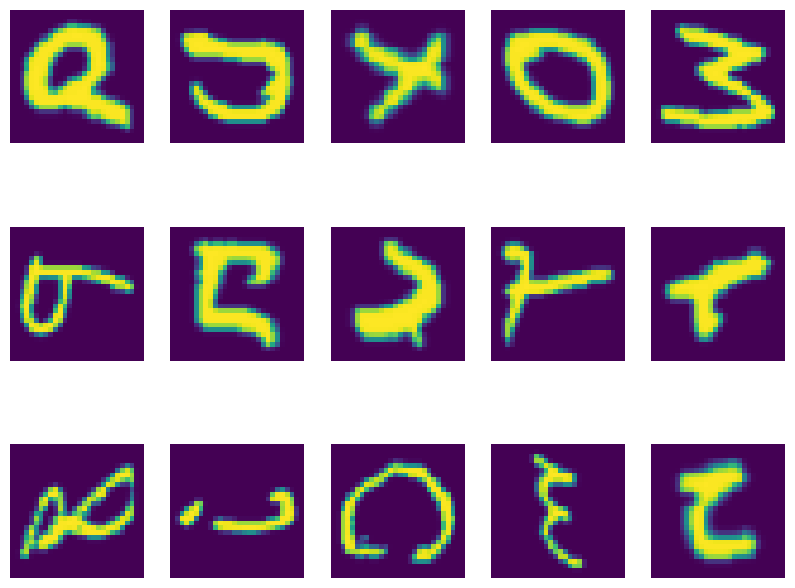

In [5]:
X_train, y_train = shuffle(X_train, y_train, random_state=42) 

fig,axes = plt.subplots(3,5,figsize=(10,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape([28,28]))
    ax.axis('off')

In [6]:
print(X_test.shape)
print(y_test.shape)

(14799, 784)
(14799,)


In [7]:
np.unique(y_train)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

In [8]:
np.unique(y_test)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

In [9]:
print(len(y_train)+len(y_test))

103598


In [10]:
print(len(X_train) + len(X_test))

103598


In [11]:
X = np.concatenate((X_train, X_test), axis = 0)
y = np.concatenate((y_train, y_test), axis = 0)
print(y.shape)

(103598,)


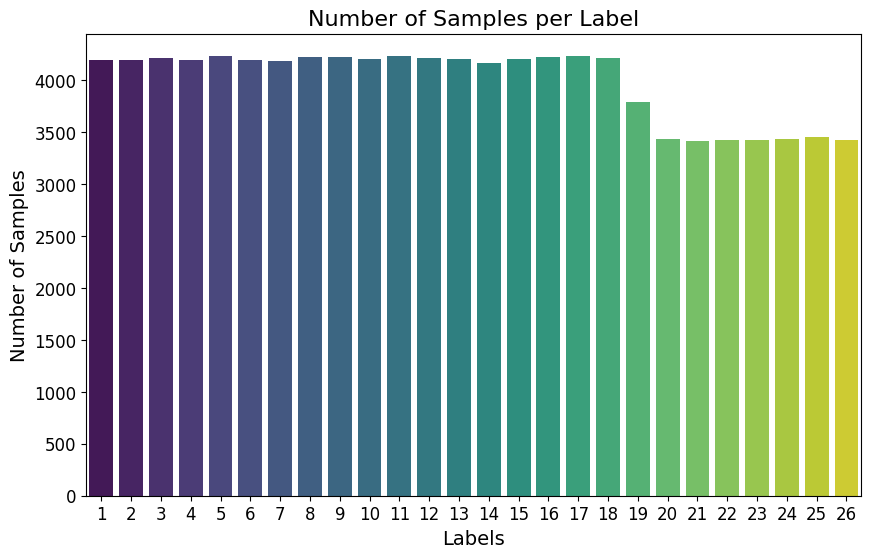

In [12]:
# y is already a 1D array (no need for np.argmax)
label_counts = pd.Series(y).value_counts().sort_index()

# Visualize the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Number of Samples per Label', fontsize=16)
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [13]:
from imblearn.under_sampling import RandomUnderSampler

# Initialize RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_resample(X, y)

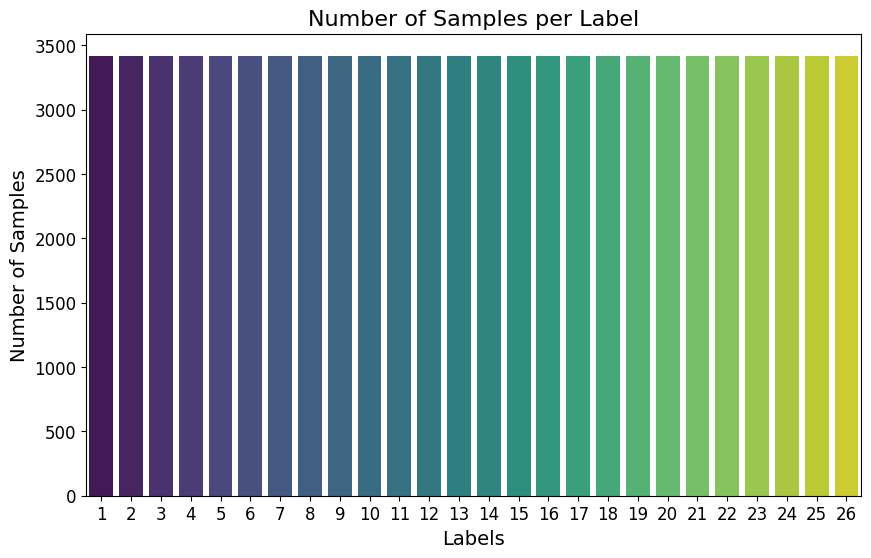

In [14]:
label_counts = pd.Series(y).value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Number of Samples per Label', fontsize=16)
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [15]:
X.shape

(88894, 784)

In [16]:
np.unique(y)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

In [17]:
X_norm = X.astype('float32') / 255.0 

X_reshaped = X_norm.reshape(-1, 28, 28, 1)

X_rgb = np.repeat(X_reshaped, 3, axis=-1)

print("Images shape after RGB conversion:", X_rgb.shape)

Images shape after RGB conversion: (88894, 28, 28, 3)


In [18]:
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(y.reshape(-1, 1))

y_encoded = encoder.transform(y.reshape(-1, 1))

print("images shape:", X_rgb.shape)
print("labels shape:", y_encoded.shape)

images shape: (88894, 28, 28, 3)
labels shape: (88894, 26)


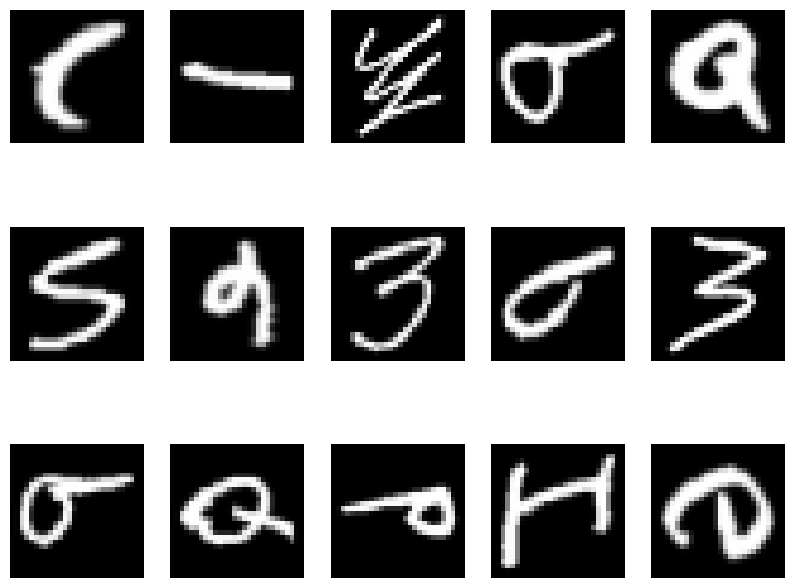

In [19]:
X_shuffled, y_shuffled = shuffle(X_rgb, y, random_state=42)

# Visualize the reshaped EMNIST images in RGB
fig, axes = plt.subplots(3, 5, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_shuffled[i])
    ax.axis('off')

In [20]:
#split into 80% training, 10% validation, 10% testing
# X_data and y_data represent your features and labels
X_train, X_temp, y_train, y_temp = train_test_split(
    X_rgb, y_encoded, test_size=0.2, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(71115, 28, 28, 3)
(71115, 26)
(8889, 28, 28, 3)
(8889, 26)
(8890, 28, 28, 3)
(8890, 26)


In [21]:
# Data Augmentation (Before Resize)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
                            rotation_range=20,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=False,
                            fill_mode='nearest'
)


datagen.fit(X_train)
datagen.fit(X_val)
datagen.fit(X_test)
print('Done')

Done


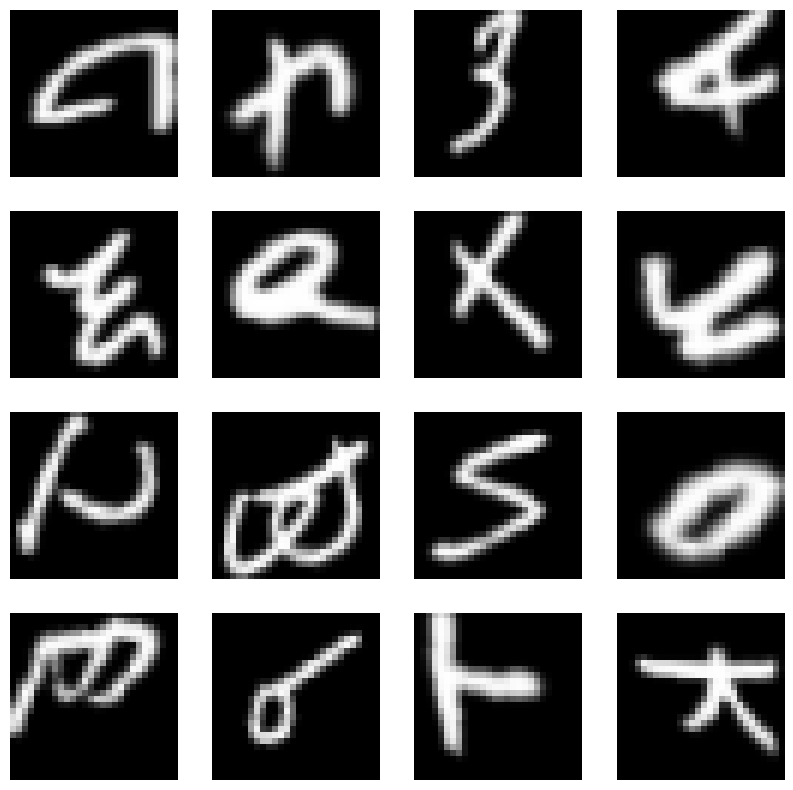

In [22]:
augmented_images = datagen.flow(X_train, batch_size=1, shuffle=True)

plt.figure(figsize=(10, 10))
for i in range(16):
    augmented_img = next(augmented_images)[0].astype('float32')
    plt.subplot(4, 4, i+1) 
    plt.imshow(augmented_img)
    plt.axis('off')
plt.show()

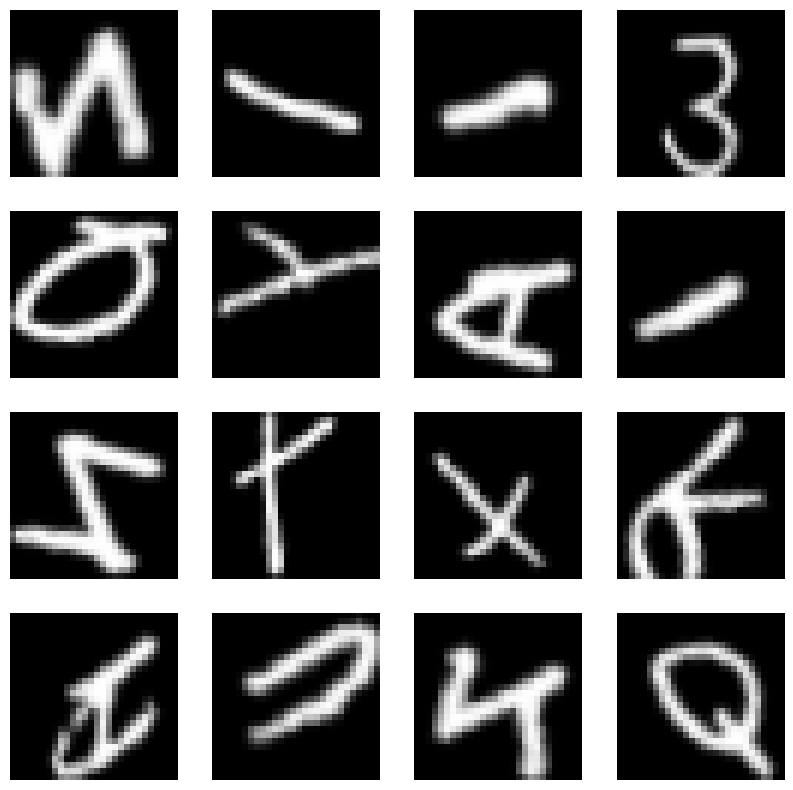

In [23]:
augmented_images = datagen.flow(X_val, batch_size=1, shuffle=True)

plt.figure(figsize=(10, 10))
for i in range(16):
    augmented_img = next(augmented_images)[0].astype('float32')
    plt.subplot(4, 4, i+1) 
    plt.imshow(augmented_img)
    plt.axis('off')
plt.show()

In [24]:
# Resizing images to 71x71
X_train_resized = tf.image.resize(X_train, [71, 71])
X_val_resized = tf.image.resize(X_val, [71, 71])
X_test_resized = tf.image.resize(X_test, [71, 71])

# Verify the shapes
print("X_train_resized shape:", X_train_resized.shape)
print("X_val_resized shape:", X_val_resized.shape)
print("X_test_resized shape:", X_test_resized.shape)

X_train_resized shape: (71115, 71, 71, 3)
X_val_resized shape: (8889, 71, 71, 3)
X_test_resized shape: (8890, 71, 71, 3)


In [25]:
from tensorflow.keras.optimizers import Adam
# Load the Xception base model without the top (classification) layer
base_model = Xception(weights='imagenet', include_top=False, input_shape=(71, 71, 3))

# Freeze the base model layers 
base_model.trainable = False

# Build Model 
model = Sequential()

# Base Model 
model.add(base_model)

# Add 2D pooling
model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu'))
# Dropout Layer  to prevent overfitting by randomly dropping a fraction of input units during training.
model.add(Dropout(0.3))

# Dense Layer 
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# Output Layer  # (y_encoded.shape[1] = 26 letter in english)
model.add(Dense(y_encoded.shape[1], activation='softmax')) 

# Compile
model.compile(optimizer=Adam(learning_rate=0.001) , loss='categorical_crossentropy', metrics=['accuracy'])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Define EarlyStopping callback 
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
xception_history = model.fit(datagen.flow(X_train_resized, y_train, batch_size=32),
                    validation_data=(X_val_resized, y_val),
                    epochs=30,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/30


I0000 00:00:1734575322.978708     132 service.cc:145] XLA service 0x7ba9b00023f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734575322.978784     132 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734575322.978791     132 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   3/2223 ━━━━━━━━━━━━━━━━━━━━ 1:46 48ms/step - accuracy: 0.0312 - loss: 3.4693  

I0000 00:00:1734575330.418099     132 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2223/2223 ━━━━━━━━━━━━━━━━━━━━ 135s 55ms/step - accuracy: 0.4610 - loss: 1.7540 - val_accuracy: 0.7292 - val_loss: 0.8137 - learning_rate: 0.0010
Epoch 2/30
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 112s 50ms/step - accuracy: 0.6605 - loss: 1.0626 - val_accuracy: 0.7945 - val_loss: 0.6517 - learning_rate: 0.0010
Epoch 3/30
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 111s 50ms/step - accuracy: 0.6990 - loss: 0.9520 - val_accuracy: 0.7975 - val_loss: 0.6070 - learning_rate: 0.0010
Epoch 4/30
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 112s 50ms/step - accuracy: 0.7155 - loss: 0.8865 - val_accuracy: 0.8089 - val_loss: 0.5923 - learning_rate: 0.0010
Epoch 5/30
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 111s 50ms/step - accuracy: 0.7306 - loss: 0.8511 - val_accuracy: 0.8085 - val_loss: 0.5764 - learning_rate: 0.0010
Epoch 6/30
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 110s 49ms/step - accuracy: 0.7407 - loss: 0.8178 - val_accuracy: 0.8269 - val_loss: 0.5358 - learning_rate: 0.0010
Epoch 7/30
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 111s 50ms/step - accuracy: 

In [27]:
# Gradually unfreeze the last layers
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Keep first layers frozen
    layer.trainable = False

# Recompile with a smaller learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
Xception_history_fine = model.fit(datagen.flow(X_train_resized, y_train, batch_size=32),
                         validation_data=(X_val_resized, y_val),
                         epochs=10,
                         callbacks=[early_stopping])

Epoch 1/10
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 141s 57ms/step - accuracy: 0.4857 - loss: 2.5081 - val_accuracy: 0.8108 - val_loss: 0.6042
Epoch 2/10
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 116s 52ms/step - accuracy: 0.7289 - loss: 0.8885 - val_accuracy: 0.8658 - val_loss: 0.4173
Epoch 3/10
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 120s 54ms/step - accuracy: 0.7955 - loss: 0.6497 - val_accuracy: 0.8875 - val_loss: 0.3420
Epoch 4/10
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 116s 52ms/step - accuracy: 0.8302 - loss: 0.5486 - val_accuracy: 0.8982 - val_loss: 0.3081
Epoch 5/10
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 116s 52ms/step - accuracy: 0.8525 - loss: 0.4691 - val_accuracy: 0.9053 - val_loss: 0.2798
Epoch 6/10
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 117s 52ms/step - accuracy: 0.8625 - loss: 0.4338 - val_accuracy: 0.9117 - val_loss: 0.2614
Epoch 7/10
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 115s 51ms/step - accuracy: 0.8712 - loss: 0.4040 - val_accuracy: 0.9184 - val_loss: 0.2506
Epoch 8/10
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 116s 52ms/step - accuracy: 

In [30]:
# Evaluate on test
loss, accuracy = model.evaluate(X_test_resized, y_test, verbose=2)
print(f"Testing Loss: {loss:.4f}")
print(f"Testing Accuracy: {accuracy:.4f}")

278/278 - 8s - 30ms/step - accuracy: 0.9340 - loss: 0.2048
Testing Loss: 0.2048
Testing Accuracy: 0.9340


/tmp/ipykernel_71/1446777946.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


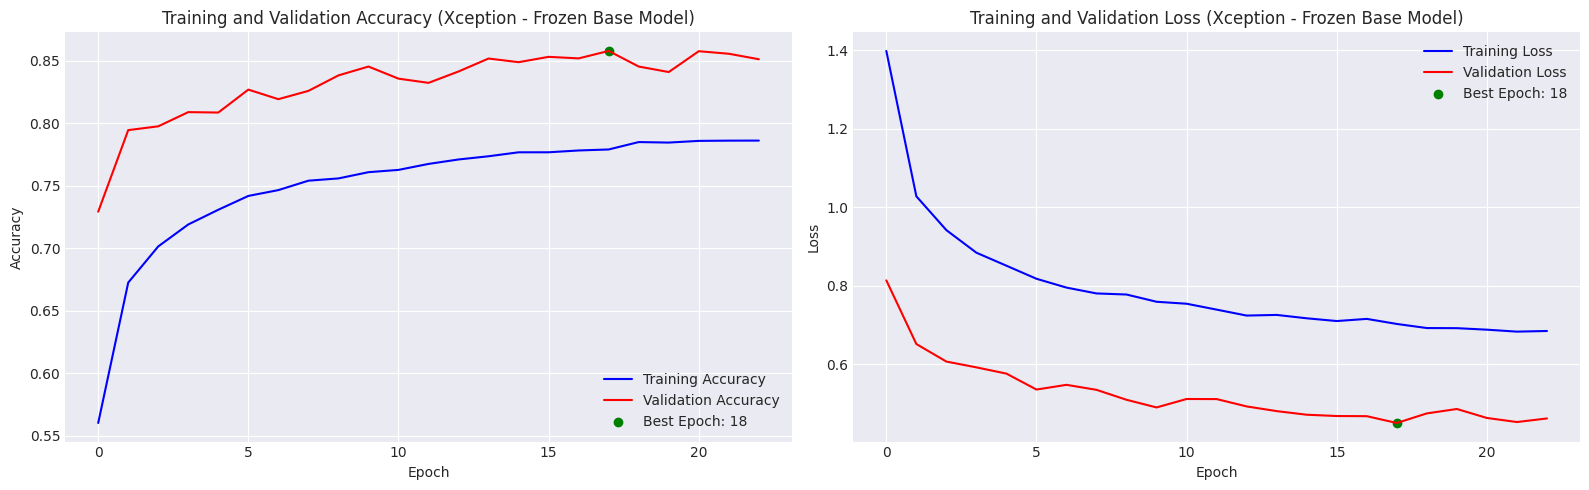

In [31]:
#before fine tuning
# Get the epoch with the highest validation accuracy
best_epoch = xception_history.history['val_accuracy'].index(max(xception_history.history['val_accuracy'])) + 1

# Set the background style
plt.style.use('seaborn-darkgrid')

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(xception_history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(xception_history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, xception_history.history['val_accuracy'][best_epoch - 1], 
               color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy (Xception - Frozen Base Model)')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(xception_history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(xception_history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, xception_history.history['val_loss'][best_epoch - 1], 
               color='green', label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss (Xception - Frozen Base Model)')
axs[1].legend()

plt.tight_layout()
plt.show()


/tmp/ipykernel_71/2549746281.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


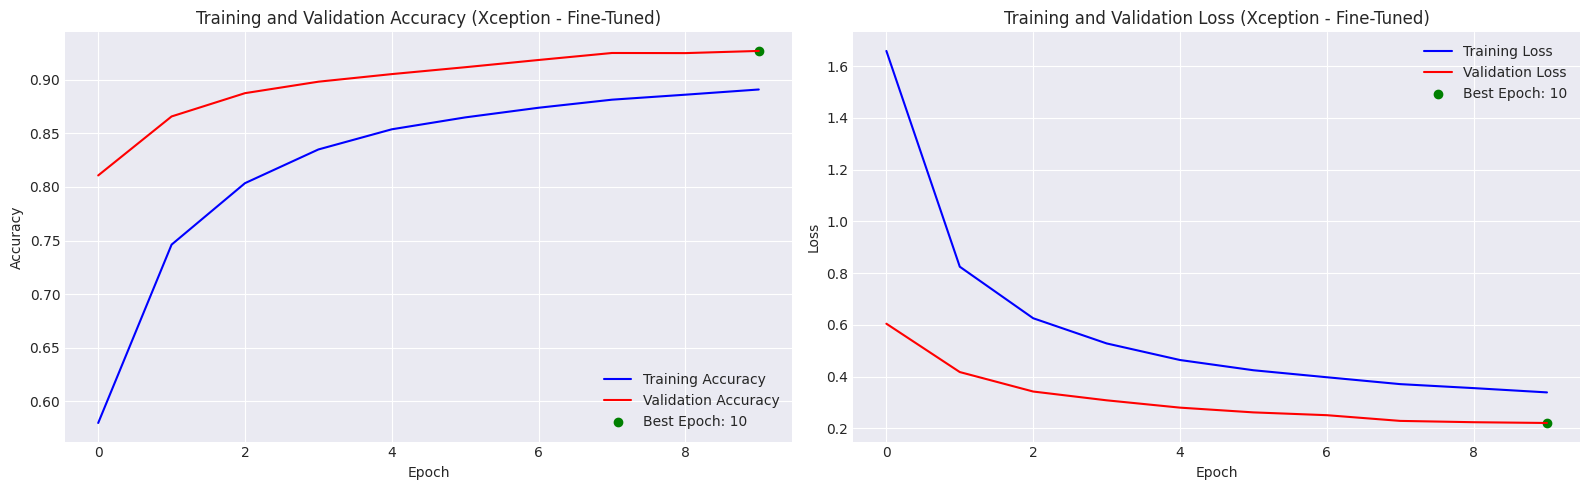

In [32]:
#after fine tuning
# Get the epoch with the highest validation accuracy
best_epoch_finetune = Xception_history_fine.history['val_accuracy'].index(max(Xception_history_fine.history['val_accuracy'])) + 1

# Set the background style
plt.style.use('seaborn-darkgrid')

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(Xception_history_fine.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(Xception_history_fine.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch_finetune - 1, Xception_history_fine.history['val_accuracy'][best_epoch_finetune - 1], 
               color='green', label=f'Best Epoch: {best_epoch_finetune}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy (Xception - Fine-Tuned)')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(Xception_history_fine.history['loss'], label='Training Loss', color='blue')
axs[1].plot(Xception_history_fine.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch_finetune - 1, Xception_history_fine.history['val_loss'][best_epoch_finetune - 1], 
               color='green', label=f'Best Epoch: {best_epoch_finetune}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss (Xception - Fine-Tuned)')
axs[1].legend()

plt.tight_layout()
plt.show()


278/278 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step


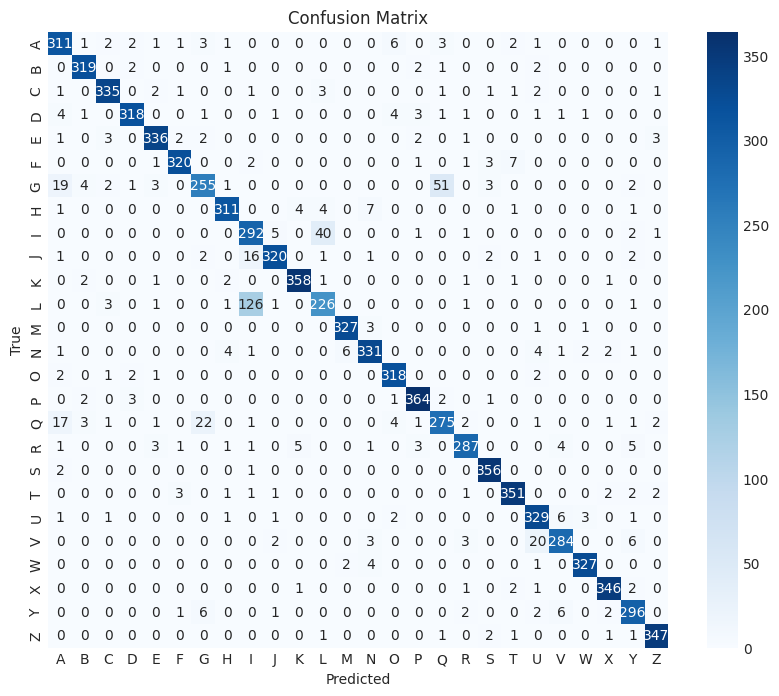

In [34]:
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.models import load_model

val_pred_labels = np.argmax(model.predict(X_val_resized), axis=1)  # Replace with your model's predictions
true_labels = np.argmax(y_val, axis=1)  # True labels from your validation set
#  Confusion Matrix_xception
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
cm = confusion_matrix(true_labels, val_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score

#recall,precision and f-score
precision = precision_score(true_labels,val_pred_labels, average='weighted')
recall = recall_score(true_labels,val_pred_labels, average='weighted')
f_score = f1_score(true_labels,val_pred_labels, average='weighted')

print(f"Precision:{precision:.3f}")
print(f"Recall:{recall:.3f}")
print(f"F1-Score:{f_score:.3f}")

report = classification_report(true_labels, val_pred_labels, target_names=class_names, digits=4)
print(report)

Precision:0.929
Recall:0.927
F1-Score:0.927
              precision    recall  f1-score   support

           A     0.8591    0.9284    0.8924       335
           B     0.9608    0.9755    0.9681       327
           C     0.9626    0.9599    0.9613       349
           D     0.9695    0.9436    0.9564       337
           E     0.9600    0.9600    0.9600       350
           F     0.9726    0.9552    0.9639       335
           G     0.8763    0.7478    0.8070       341
           H     0.9599    0.9453    0.9525       329
           I     0.6606    0.8538    0.7449       342
           J     0.9639    0.9249    0.9440       346
           K     0.9728    0.9755    0.9741       367
           L     0.8188    0.6278    0.7107       360
           M     0.9761    0.9849    0.9805       332
           N     0.9457    0.9377    0.9417       353
           O     0.9493    0.9755    0.9622       326
           P     0.9655    0.9759    0.9707       373
           Q     0.8209    0.8283    

278/278 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


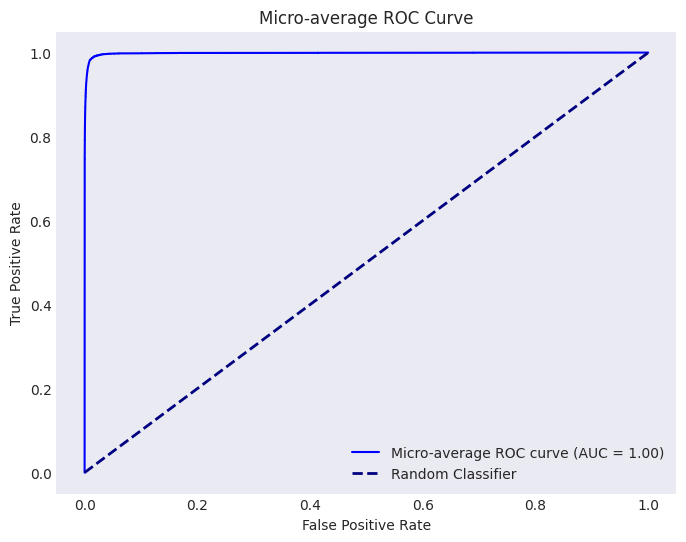

Micro-average AUC: 0.9986


In [36]:
# Predicted probabilities
y_val_prob = model.predict(X_val_resized) 


# Compute micro-average ROC curve and AUC, Flatten for micro-average
fpr, tpr, _ = roc_curve(y_val.ravel(), y_val_prob.ravel())  
roc_auc_micro = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"Micro-average ROC curve (AUC = {roc_auc_micro:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Classifier")

# Customize plot
plt.title("Micro-average ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"Micro-average AUC: {roc_auc_micro:.4f}")

278/278 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step


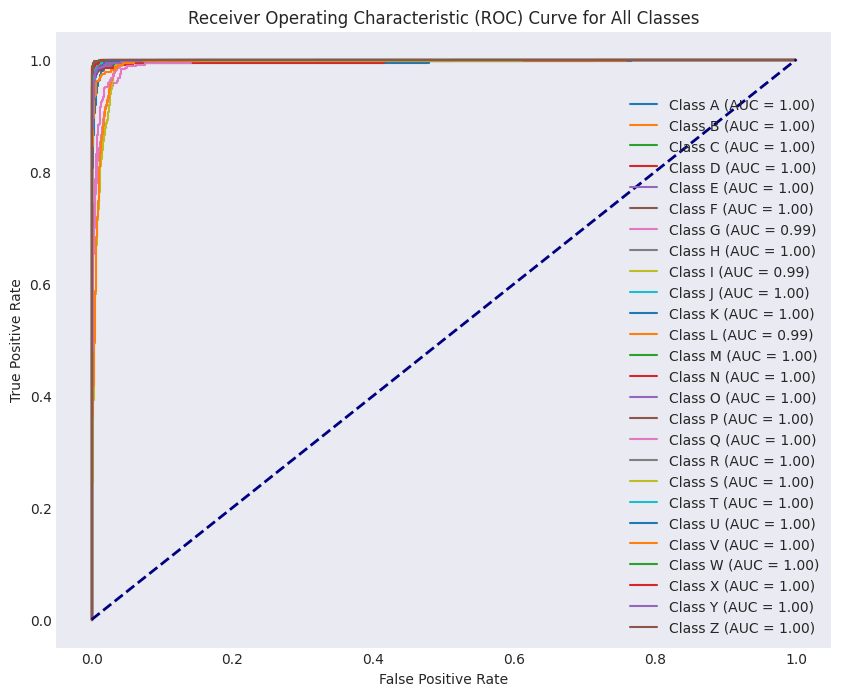

In [38]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Predicted probabilities
y_val_prob = model.predict(X_val_resized)  

# Compute AUC for multi-class classification (macro-average)
roc_auc = roc_auc_score(y_val, y_val_prob, multi_class='ovr')

# Plot ROC Curve for all classes
fpr = {}
tpr = {}
roc_auc_values = {}
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
               'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

plt.figure(figsize=(10, 8))

for i in range(y_val.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_val_prob[:, i])
    roc_auc_values[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc_values[i]:.2f})")

# Plot the diagonal line for random chance
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Customize the plot
plt.title("Receiver Operating Characteristic (ROC) Curve for All Classes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.grid()
plt.show()


